<a href="https://colab.research.google.com/github/kayrocsilva/P1_Machine_Learning/blob/main/analise_balance_sheet_ibm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Avaliação Prática – Análise de Demonstrativos Contábeis com Alpha
Vantage (Balance Sheet)
Disciplina: Análise Financeira Automatizada com APIs de Mercado
Ambiente: Google Colab + Python
Fonte de Dados: https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=IBM
Objetivo da Avaliação
Você deverá desenvolver um projeto em Python que: - Consome os dados de demonstrativo contábil da IBM usando a API BALANCE_SHEET da Alpha
Vantage - Extrai dados relevantes do balanço patrimonial (ativo total, passivo total, capital próprio, caixa,
investimentos, etc.) - Calcula indicadores financeiros relevantes como índice de liquidez, endividamento e
alavancagem - Classifica o estado financeiro da empresa em cinco categorias com base nesses indicadores - Treina um classificador Naive Bayes para prever a categoria financeira de um balanço com base
em múltiplos períodos - Exporta o dataset final com as análises e apresenta visualizações que mostram os padrões
contábeis da empresa
Etapas Esperadas da Atividade
1. 1. Consulta ao endpoint BALANCE_SHEET com símbolo 'IBM'
2. 2. Extração de dados anuais e trimestrais dos campos: totalAssets, totalLiabilities,
totalShareholderEquity, cashAndCashEquivalents, longTermDebt, shortTermInvestments
3. 3. Cálculo de indicadores como:
4.    - Índice de Liquidez Corrente = currentAssets / currentLiabilities
5.    
6.    - Índice de Endividamento = totalLiabilities / totalAssets - Índice de Alavancagem = totalAssets / totalShareholderEquity
7. 4. Classificação da saúde financeira em categorias: Excelente, Boa, Razoável, Ruim e Crítica
8. 5. Normalização e divisão em conjuntos de treino e teste
9. 6. Treinamento com algoritmo GaussianNB
10. 7. Avaliação com classification_report e matriz de confusão
11. 8. Visualizações: evolução dos ativos e passivos ao longo do tempo, gráfico de barras dos
índices financeiros
12. 9. Exportação do dataset para .csv com as classificações por trimestre
13. 10. Conclusão com recomendações estratégicas baseadas nos dados históricos da empresa
Exemplo de estrutura esperada do DataFrame
Campos esperados:
fiscalDateEnding | totalAssets | totalLiabilities | equity | cash | investments | liquidez |
endividamento | alavancagem | classificacao_financeira
Definição do Target: classificacao_financeira
Target categórico baseado em indicadores contábeis combinados: - Excelente: liquidez > 2.0, endividamento < 0.4, alavancagem < 2.5 - Boa: liquidez entre 1.5 e 2.0, endividamento entre 0.4 e 0.5, alavancagem < 3 - Razoável: liquidez entre 1.2 e 1.5, endividamento entre 0.5 e 0.6, alavancagem < 4 - Ruim: liquidez entre 1.0 e 1.2 ou endividamento entre 0.6 e 0.75 - Crítica: liquidez < 1.0 ou endividamento > 0.75 ou alavancagem > 5
Entrega Esperada
Repositório GitHub contendo: - Notebook: analise_balance_sheet_ibm.ipynb - Dataset exportado: indicadores_balance_sheet.csv - README.md com explicações dos cálculos, critérios de classificação e conclusão financeira

# Pré-Processamento dos Dados

## Importação das Bibliotecas

In [50]:
!pip install plotly --upgrade
!pip install squarify --upgrade

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
from IPython.display import display
import plotly.graph_objects as go
import squarify


## Importação do notebook

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Consumir a API da Alpha Vantage

### Consulta ao endpoint BALANCE_SHEET com símbolo 'IBM'

In [53]:
url = 'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=IBM&apikey=NO4OQ3DMC4P0B56E'

r = requests.get(url)
data = r.json()

print(data)

{'symbol': 'IBM', 'annualReports': [{'fiscalDateEnding': '2024-12-31', 'reportedCurrency': 'USD', 'totalAssets': '137175000000', 'totalCurrentAssets': '34482000000', 'cashAndCashEquivalentsAtCarryingValue': '13947000000', 'cashAndShortTermInvestments': '13947000000', 'inventory': '1289000000', 'currentNetReceivables': '14010000000', 'totalNonCurrentAssets': '102694000000', 'propertyPlantEquipment': 'None', 'accumulatedDepreciationAmortizationPPE': 'None', 'intangibleAssets': '10660000000', 'intangibleAssetsExcludingGoodwill': '10660000000', 'goodwill': '60706000000', 'investments': 'None', 'longTermInvestments': 'None', 'shortTermInvestments': '644000000', 'otherCurrentAssets': '4592000000', 'otherNonCurrentAssets': 'None', 'totalLiabilities': '109782000000', 'totalCurrentLiabilities': '33142000000', 'currentAccountsPayable': '4032000000', 'deferredRevenue': 'None', 'currentDebt': 'None', 'shortTermDebt': '5857000000', 'totalNonCurrentLiabilities': '76640000000', 'capitalLeaseObligatio

### Extração de dados anuais e trimestrais dos campos: totalAssets, totalLiabilities, totalShareholderEquity, cashAndCashEquivalents, longTermDebt, shortTermInvestments

In [54]:
#Foi renomeado o campo cashAndCashEquivalentsAtCarryingValue para cashAndCash somente para seguir o enunciado pedido.
"""
Para o futuro cálculo da Liquidez Corrente que é pedido no enunciado, são necessários os campos currentAssets e currentLiabilities.
Entretanto esses campos não existem no referido dataframe e para poder prosseguir com a resolução, serão utlizados também os campos,
totalCurrentAssets e totalCurrentLiabilities para o cálculo da Liquidez Corrente. Estamos optando por utilizar totalCurrentAssets e totalCurrentLiabilities
para que a Liquidez Corrente possa ser calculada somente no periodo corrente, seja ele o ano ou o trimestre. Por isso então que não adotaremos o totalAssets e totalLiabilities,
porque esses tem a influência do acumulado passado.
"""
# Dados anuais
annual_reports = pd.DataFrame(data['annualReports'])
annual_reports = annual_reports.rename(columns={'cashAndCashEquivalentsAtCarryingValue': 'cashAndCashEquivalents'})
annual_columns = ['fiscalDateEnding', 'totalAssets', 'totalLiabilities', 'totalShareholderEquity', 'cashAndCashEquivalents', 'longTermDebt', 'shortTermInvestments', 'totalCurrentAssets', 'totalCurrentLiabilities']
annual_reports = annual_reports[annual_columns]

# Dados trimestrais
quarterly_reports = pd.DataFrame(data['quarterlyReports'])
quarterly_reports = quarterly_reports.rename(columns={'cashAndCashEquivalentsAtCarryingValue': 'cashAndCashEquivalents'})
quarterly_columns = ['fiscalDateEnding', 'totalAssets', 'totalLiabilities', 'totalShareholderEquity', 'cashAndCashEquivalents', 'longTermDebt', 'shortTermInvestments','totalCurrentAssets', 'totalCurrentLiabilities']
quarterly_reports = quarterly_reports[quarterly_columns]


print("DADOS ANUAIS ABAIXO")
print(annual_reports)

print("DADOS TRIMESTRAIS ABAIXO")
print(quarterly_reports)



DADOS ANUAIS ABAIXO
   fiscalDateEnding   totalAssets totalLiabilities totalShareholderEquity  \
0        2024-12-31  137175000000     109782000000            27307000000   
1        2023-12-31  135241000000     112628000000            22533000000   
2        2022-12-31  127243000000     105222000000            21944000000   
3        2021-12-31  132001000000     113005000000            18901000000   
4        2020-12-31  155970000000     135245000000            20597000000   
5        2019-12-31  152186000000     131201000000            20841000000   
6        2018-12-31  123382000000     106452000000            16796000000   
7        2017-12-31  125355000000     107631000000            17594000000   
8        2016-12-31  117470000000      99078000000            18246000000   
9        2015-12-31  110495000000      96071000000            14262000000   
10       2014-12-31  117532000000     105518000000            11868000000   
11       2013-12-31  126223000000     103294000000      

## Tratamento de dados que estão em string para numeric

In [55]:
#Não é possível realizar operações matématicas com os dados que estão no formato de string, para isso converteremos eles para o formato numérico.

#Dados Anuais
annual_reports['totalAssets'] = pd.to_numeric(annual_reports['totalAssets'])
annual_reports['totalLiabilities'] = pd.to_numeric(annual_reports['totalLiabilities'])
annual_reports['totalCurrentLiabilities'] = pd.to_numeric(annual_reports['totalCurrentLiabilities'])
annual_reports['totalCurrentAssets'] = pd.to_numeric(annual_reports['totalCurrentAssets'])
annual_reports['totalShareholderEquity'] = pd.to_numeric(annual_reports['totalShareholderEquity'])

#Dados Trimestrais
quarterly_reports['totalAssets'] = pd.to_numeric(quarterly_reports['totalAssets'])
quarterly_reports['totalLiabilities'] = pd.to_numeric(quarterly_reports['totalLiabilities'])
quarterly_reports['totalCurrentLiabilities'] = pd.to_numeric(quarterly_reports['totalCurrentLiabilities'])
quarterly_reports['totalCurrentAssets'] = pd.to_numeric(quarterly_reports['totalCurrentAssets'])
quarterly_reports['totalShareholderEquity'] = pd.to_numeric(quarterly_reports['totalShareholderEquity'])

## Cálculo dos indicadores

In [56]:
#Indicadores anuais

#Liquidez
annual_reports['liquidez'] = annual_reports['totalCurrentAssets'] / annual_reports['totalCurrentLiabilities']

#Endividamento
annual_reports['endividamento'] = annual_reports['totalLiabilities'] / annual_reports['totalAssets']

#Alanvancagem
annual_reports['alavancagem']= annual_reports['totalAssets'] / annual_reports['totalShareholderEquity']


#Indicadores trimestrais(_q) (Para diferenciar os dados trimestrais de anuais, sera acrescido "_q" nos campos trimestrais)

#Liquidez_q
quarterly_reports['liquidez_q'] = quarterly_reports['totalCurrentAssets'] / quarterly_reports['totalCurrentLiabilities']

#Endividamento_q
quarterly_reports['endividamento_q'] = quarterly_reports['totalLiabilities'] / quarterly_reports['totalAssets']

#Alanvancagem_q
quarterly_reports['alavancagem_q']= quarterly_reports['totalAssets'] / quarterly_reports['totalShareholderEquity']

print("DADOS ANUAIS ABAIXO")
print(annual_reports)

print("DADOS TRIMESTRAIS ABAIXO")
print(quarterly_reports)

DADOS ANUAIS ABAIXO
   fiscalDateEnding   totalAssets  totalLiabilities  totalShareholderEquity  \
0        2024-12-31  137175000000      109782000000             27307000000   
1        2023-12-31  135241000000      112628000000             22533000000   
2        2022-12-31  127243000000      105222000000             21944000000   
3        2021-12-31  132001000000      113005000000             18901000000   
4        2020-12-31  155970000000      135245000000             20597000000   
5        2019-12-31  152186000000      131201000000             20841000000   
6        2018-12-31  123382000000      106452000000             16796000000   
7        2017-12-31  125355000000      107631000000             17594000000   
8        2016-12-31  117470000000       99078000000             18246000000   
9        2015-12-31  110495000000       96071000000             14262000000   
10       2014-12-31  117532000000      105518000000             11868000000   
11       2013-12-31  12622300000

###  Classificação da saúde financeira em categorias: Excelente, Boa, Razoável, Ruim e Crítica



In [57]:
# Classificação considerando um intervalo de tempo anual
def classificar_financeira(row):
    liquidez = row['liquidez']
    endividamento = row['endividamento']
    alavancagem = row['alavancagem']

    if liquidez > 2.0 and endividamento < 0.4 and alavancagem < 2.5:
        return 'Excelente'
    elif 1.5 < liquidez <= 2.0 and 0.4 <= endividamento <= 0.5 and alavancagem < 3:
        return 'Boa'
    elif 1.2 < liquidez <= 1.5 and 0.5 < endividamento <= 0.6 and alavancagem < 4:
        return 'Razoável'
    elif (1.0 <= liquidez <= 1.2) or (0.6 < endividamento <= 0.75):
        return 'Ruim'
    elif liquidez < 1.0 or endividamento > 0.75 or alavancagem > 5:
        return 'Crítica'

annual_reports['classificacao'] = annual_reports.apply(classificar_financeira, axis=1)

print("DADOS ANUAIS ABAIXO")
pd.set_option('display.max_rows', None)
print(annual_reports)

# Classificação sonsiderando um intervalo de tempo trimestral(_q)
def classificar_financeira_q(row):
    liquidez_q = row['liquidez_q']
    endividamento_q = row['endividamento_q']
    alavancagem_q = row['alavancagem_q']

    if liquidez_q > 2.0 and endividamento_q < 0.4 and alavancagem_q < 2.5:
        return 'Excelente'
    elif 1.5 < liquidez_q <= 2.0 and 0.4 <= endividamento_q <= 0.5 and alavancagem_q < 3:
        return 'Boa'
    elif 1.2 < liquidez_q <= 1.5 and 0.5 < endividamento_q <= 0.6 and alavancagem_q < 4:
        return 'Razoável'
    elif (1.0 <= liquidez_q <= 1.2) or (0.6 < endividamento_q <= 0.75):
        return 'Ruim'
    elif liquidez_q < 1.0 or endividamento_q > 0.75 or alavancagem_q > 5:
        return 'Crítica'

quarterly_reports['classificacao_q'] = quarterly_reports.apply(classificar_financeira_q, axis=1)

print("DADOS TRIMESTRAIS ABAIXO")
pd.set_option('display.max_rows', None)
print(quarterly_reports)




DADOS ANUAIS ABAIXO
   fiscalDateEnding   totalAssets  totalLiabilities  totalShareholderEquity  \
0        2024-12-31  137175000000      109782000000             27307000000   
1        2023-12-31  135241000000      112628000000             22533000000   
2        2022-12-31  127243000000      105222000000             21944000000   
3        2021-12-31  132001000000      113005000000             18901000000   
4        2020-12-31  155970000000      135245000000             20597000000   
5        2019-12-31  152186000000      131201000000             20841000000   
6        2018-12-31  123382000000      106452000000             16796000000   
7        2017-12-31  125355000000      107631000000             17594000000   
8        2016-12-31  117470000000       99078000000             18246000000   
9        2015-12-31  110495000000       96071000000             14262000000   
10       2014-12-31  117532000000      105518000000             11868000000   
11       2013-12-31  12622300000

### Visualização Dataframe trimestral

## Normalização e divisão em conjuntos de treino e teste

In [58]:
# Normalização e divisão considerando dados anuais
model_data = annual_reports[['liquidez', 'endividamento', 'alavancagem', 'classificacao']]


# Separação em features(x) e target(y)
X = model_data[['liquidez', 'endividamento', 'alavancagem']]
y = model_data['classificacao']

# Divisão estratificada treino-teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Análise de distribuição com mais detalhes
print("\nAnalise Anual:")
print("\nDistribuição das classes:")
print(f"\nConjunto completo ({len(y)} amostras):\n{y.value_counts(normalize=True).to_string()}")
print(f"\nTreino ({len(y_train)} amostras):\n{y_train.value_counts(normalize=True).to_string()}")
print(f"\nTeste ({len(y_test)} amostras):\n{y_test.value_counts(normalize=True).to_string()}")

# Normalização com verificação estatística trimestral
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Normalização e divisão considerando dados Trimestrais

model_data_q = quarterly_reports[['liquidez_q', 'endividamento_q', 'alavancagem_q', 'classificacao_q']]


# Separação em features(x) e target(y) trimestral
X_q = model_data_q[['liquidez_q', 'endividamento_q', 'alavancagem_q']]
y_q = model_data_q['classificacao_q']

# Divisão estratificada treino-teste trimestral
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(
    X_q, y_q,
    test_size=0.2,
    random_state=42,
    stratify=y_q
)

# Análise de distribuição com mais detalhes trimestral
print("\Análise Trimestral")
print("\nDistribuição das classes:")
print(f"\nConjunto completo ({len(y_q)} amostras):\n{y_q.value_counts(normalize=True).to_string()}")
print(f"\nTreino ({len(y_train_q)} amostras):\n{y_train_q.value_counts(normalize=True).to_string()}")
print(f"\nTeste ({len(y_test_q)} amostras):\n{y_test_q.value_counts(normalize=True).to_string()}")

# Normalização com verificação estatística trimestral
scaler = StandardScaler()
X_train_scaled_q = scaler.fit_transform(X_train_q)
X_test_scaled_q = scaler.transform(X_test_q)


Analise Anual:

Distribuição das classes:

Conjunto completo (20 amostras):
classificacao
Crítica    0.65
Ruim       0.35

Treino (16 amostras):
classificacao
Crítica    0.625
Ruim       0.375

Teste (4 amostras):
classificacao
Crítica    0.75
Ruim       0.25
\Análise Trimestral

Distribuição das classes:

Conjunto completo (81 amostras):
classificacao_q
Crítica    0.567901
Ruim       0.432099

Treino (64 amostras):
classificacao_q
Crítica    0.5625
Ruim       0.4375

Teste (17 amostras):
classificacao_q
Crítica    0.588235
Ruim       0.411765


##  Visualizações: evolução dos ativos e passivos ao longo do tempo, gráfico de barras dos índices financeiros

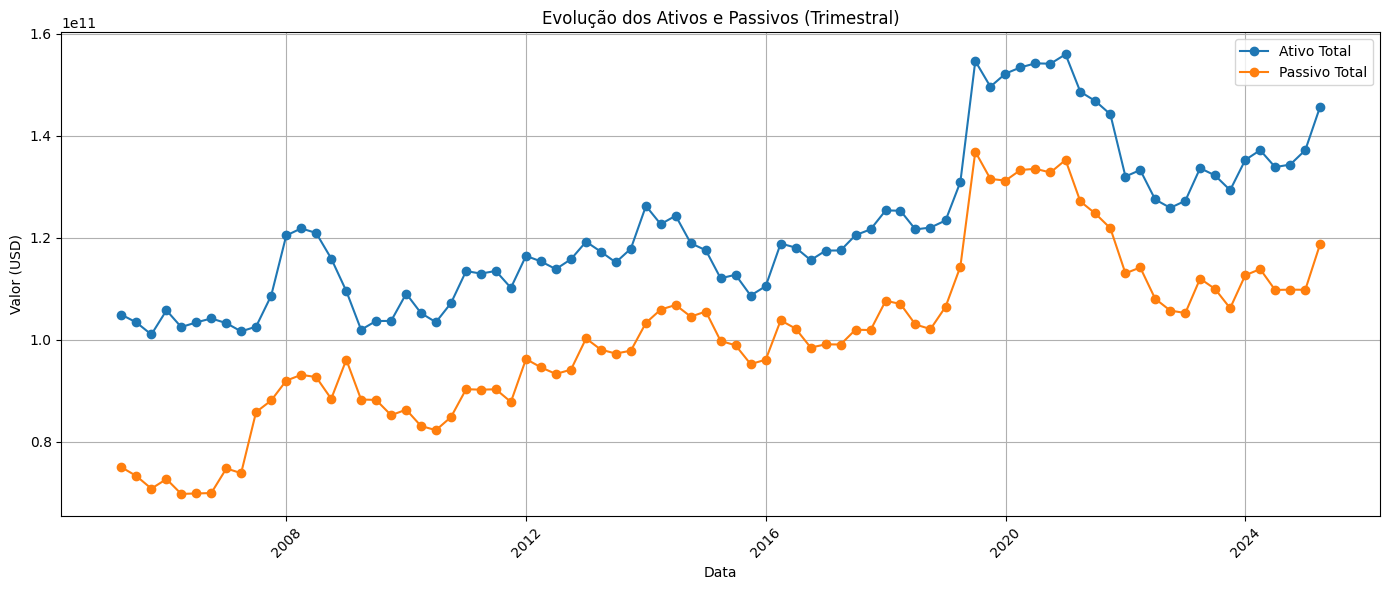

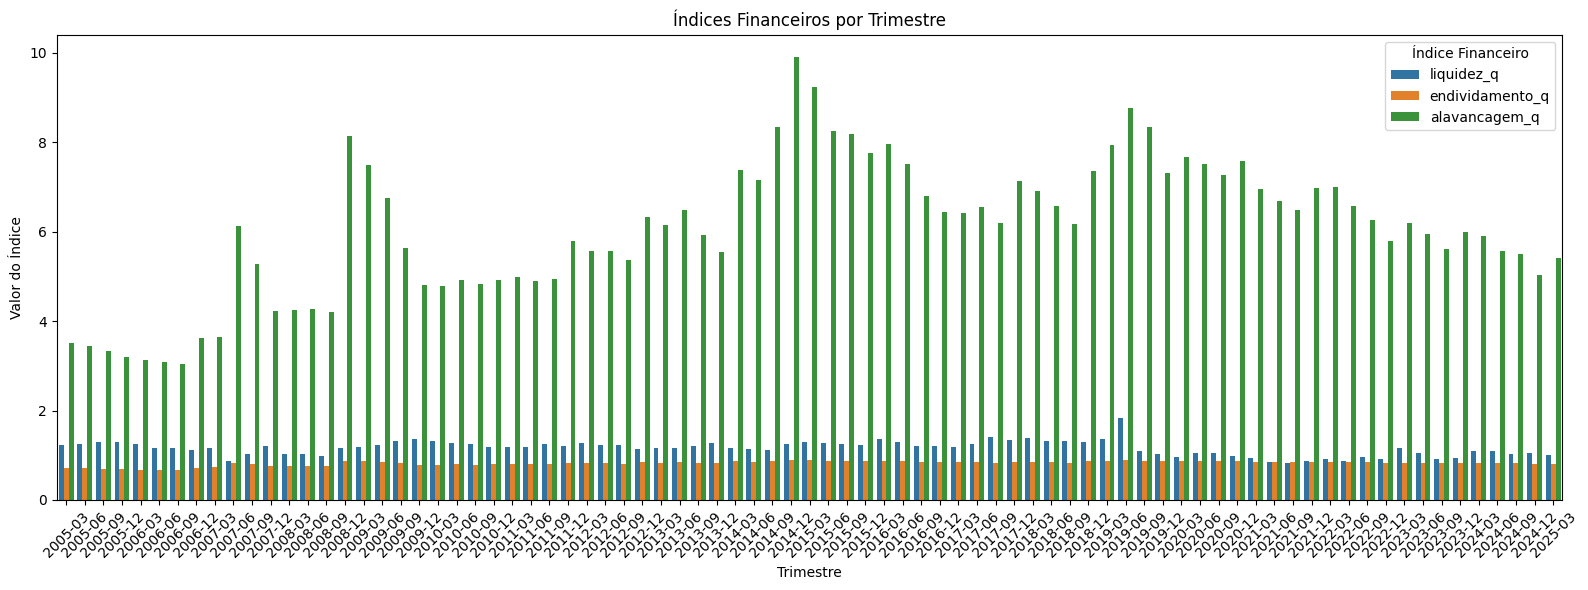

In [59]:
#Como pedido no exercício, de agora em diante só trabalharemos com os dados trimestais(_q)

# Converter datas para tipo datetime
quarterly_reports['fiscalDateEnding'] = pd.to_datetime(quarterly_reports['fiscalDateEnding'])

# Ordenar pelo tempo
quarterly_reports = quarterly_reports.sort_values(by='fiscalDateEnding')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(quarterly_reports['fiscalDateEnding'], quarterly_reports['totalAssets'].astype(float), marker='o', label='Ativo Total')
plt.plot(quarterly_reports['fiscalDateEnding'], quarterly_reports['totalLiabilities'].astype(float), marker='o', label='Passivo Total')
plt.title('Evolução dos Ativos e Passivos (Trimestral)')
plt.xlabel('Data')
plt.ylabel('Valor (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Definir dados para o gráfico
indices_plot = quarterly_reports[['fiscalDateEnding', 'liquidez_q', 'endividamento_q', 'alavancagem_q']].copy()
indices_plot['fiscalDateEnding'] = indices_plot['fiscalDateEnding'].dt.strftime('%Y-%m')

# Converter para formato long
indices_melted = indices_plot.melt(id_vars='fiscalDateEnding', var_name='Indicador', value_name='Valor')

# Plot
plt.figure(figsize=(16, 6))
sns.barplot(data=indices_melted, x='fiscalDateEnding', y='Valor', hue='Indicador')
plt.title('Índices Financeiros por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Valor do Índice')
plt.xticks(rotation=45)
plt.legend(title='Índice Financeiro')
plt.tight_layout()
plt.show()

## Outras visualizações pertinentes

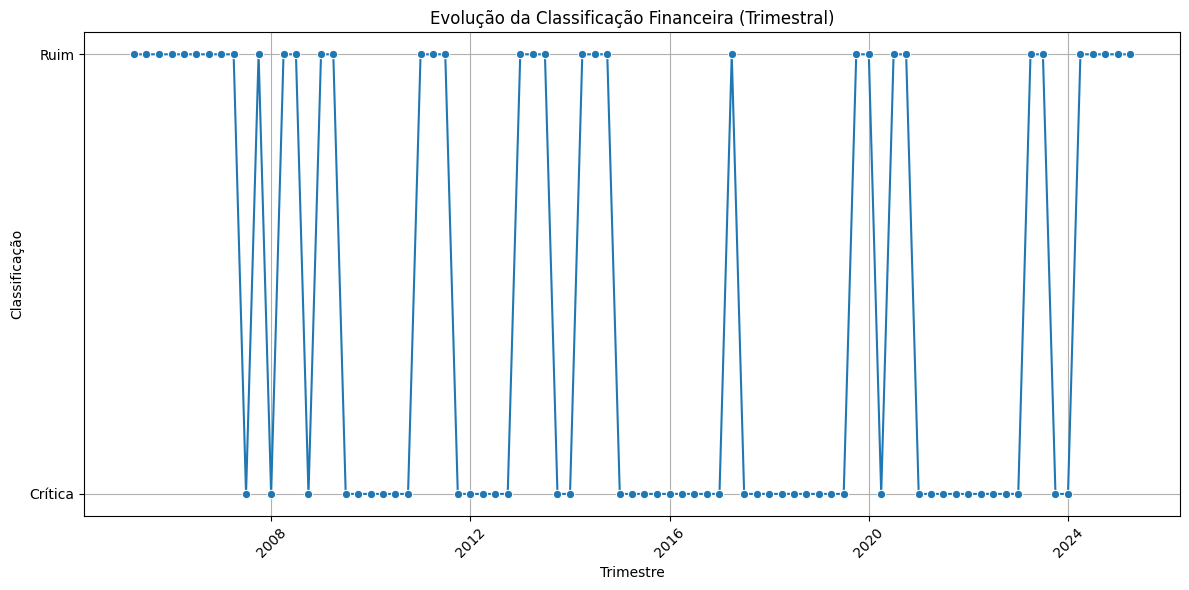

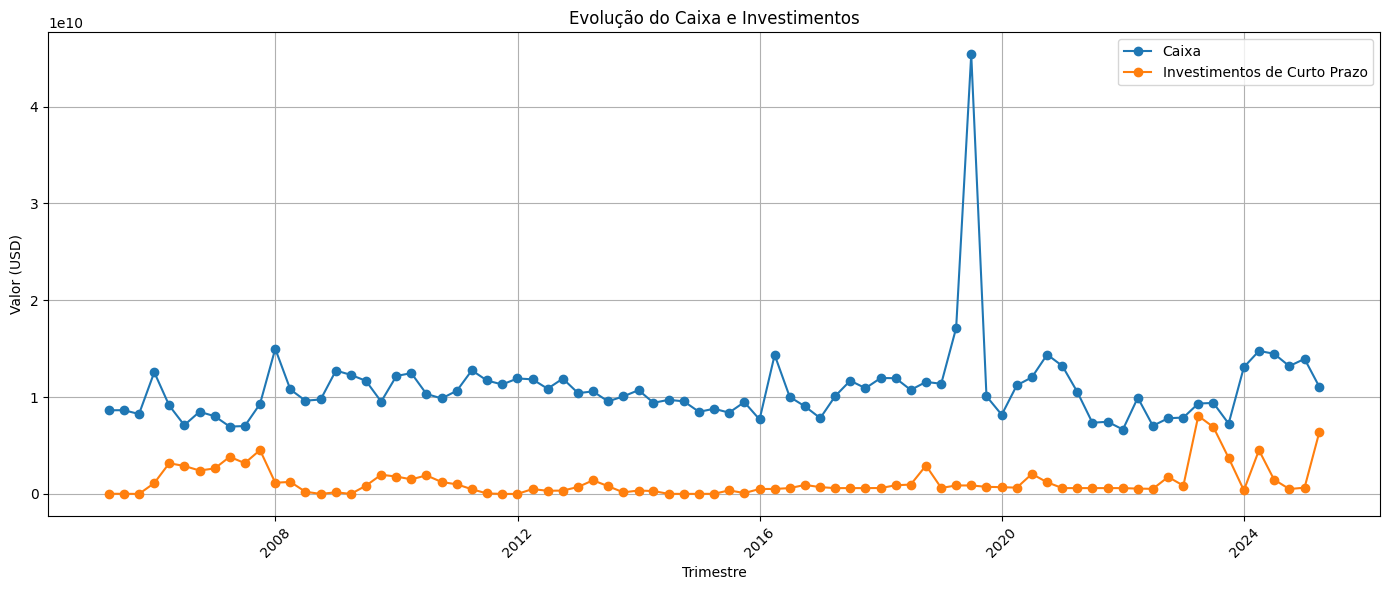

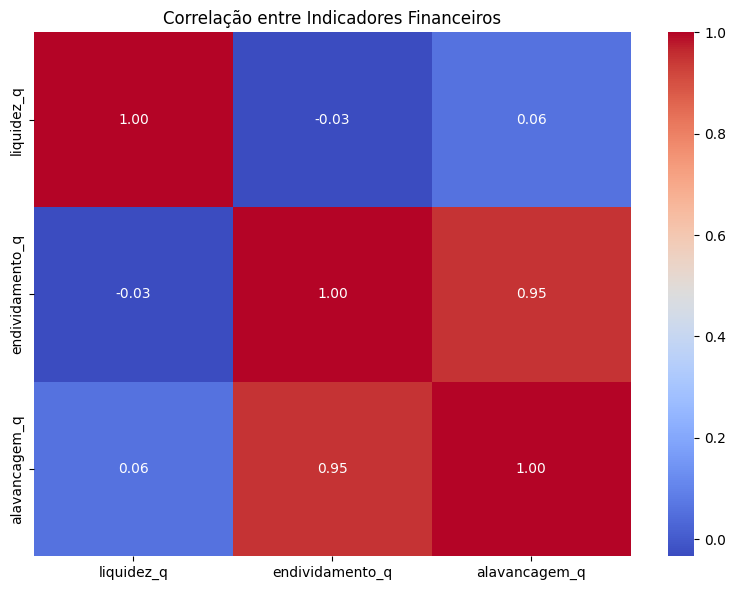

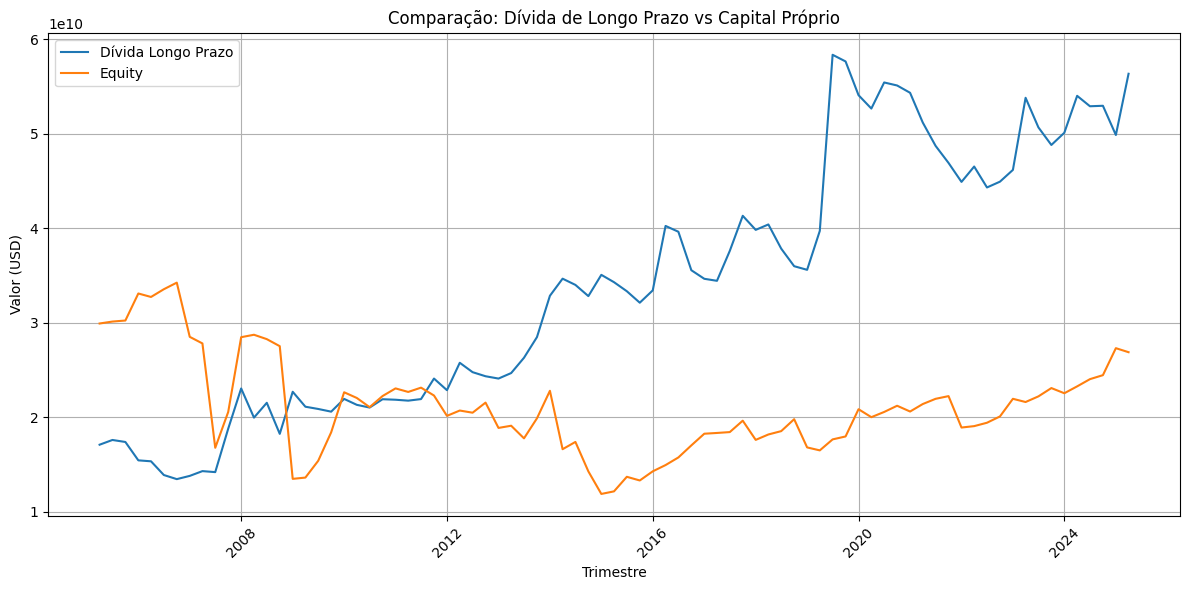

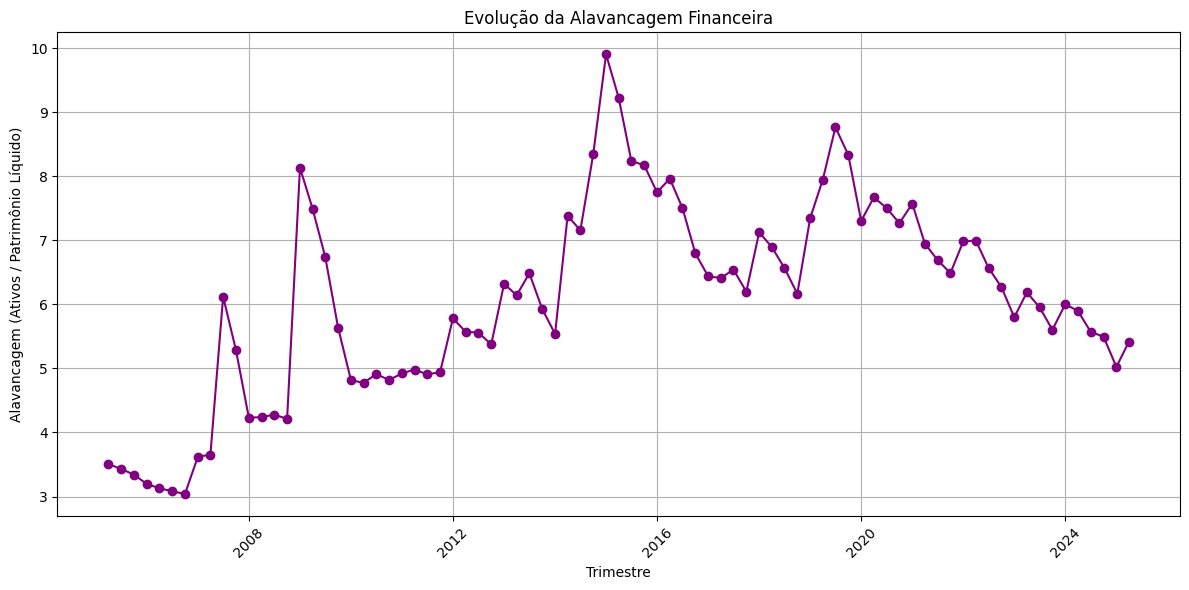

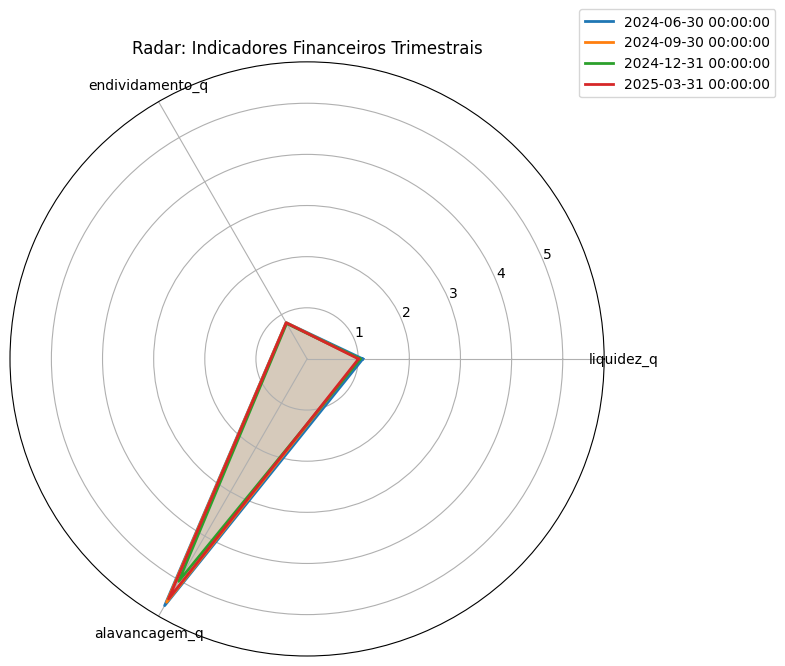

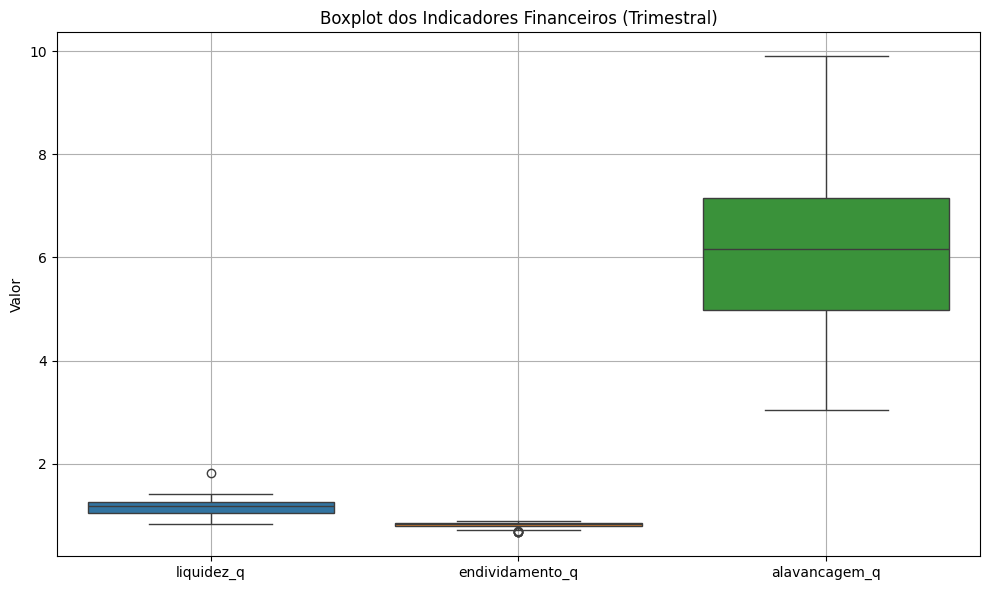

<ipython-input-60-4560ea8d579c>:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=quarterly_reports, x='classificacao_q', order=['Excelente', 'Boa', 'Razoável', 'Ruim', 'Crítica'], palette='Set2')


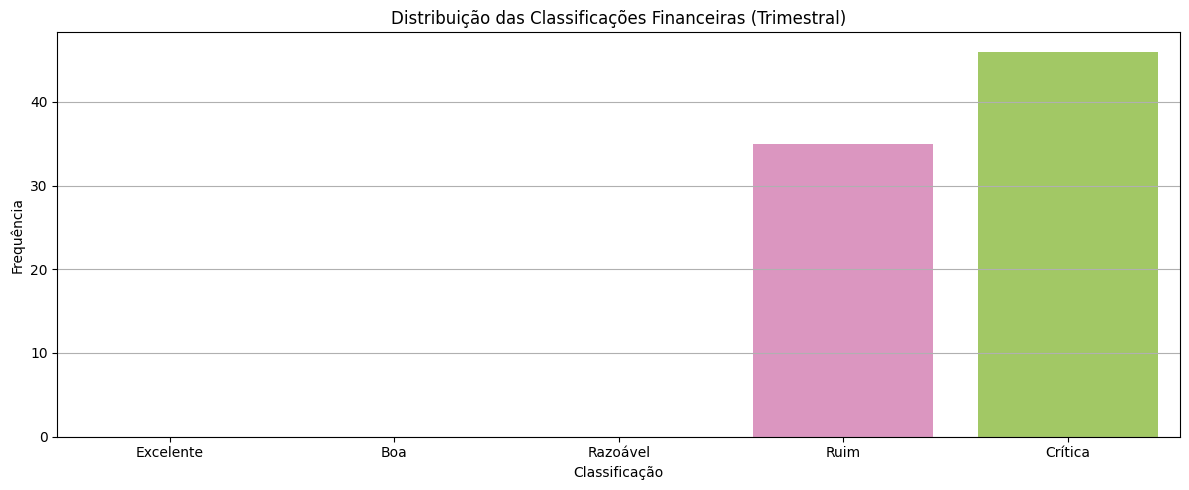

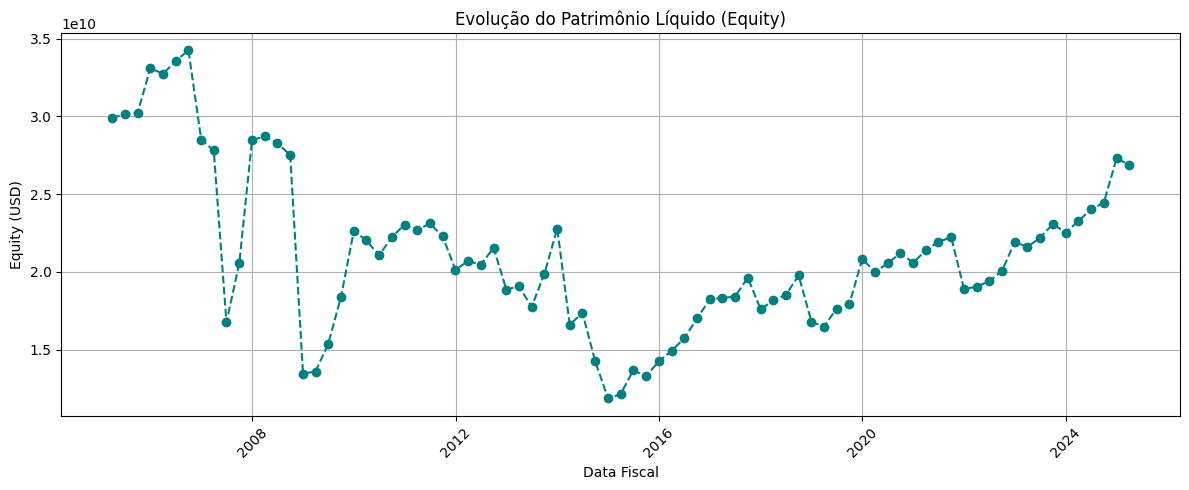

In [60]:
from math import pi

"""
Classificação Financeira ao Longo do Tempo (linha)

Justificativa: Esse gráfico mostra a evolução da classificação financeira da IBM ao longo dos trimestres, facilitando a identificação de padrões de melhora,
 estabilidade ou deterioração da saúde financeira da empresa.
É especialmente útil para investidores ou gestores acompanharem o progresso ou declínio ao longo do tempo.
"""

plt.figure(figsize=(12, 6))
sns.lineplot(x='fiscalDateEnding', y='classificacao_q', data=quarterly_reports, marker='o')
plt.title('Evolução da Classificação Financeira (Trimestral)')
plt.xlabel('Trimestre')
plt.ylabel('Classificação')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

"""
Evolução do Caixa e Investimentos
Justificativa: Permite avaliar a liquidez imediata da empresa, analisando a quantidade de recursos disponíveis em caixa e investimentos de curto prazo.
Um nível saudável indica capacidade de cobrir obrigações de curto prazo e resistência a choques econômicos.
"""
plt.figure(figsize=(14, 6))
plt.plot(quarterly_reports['fiscalDateEnding'], quarterly_reports['cashAndCashEquivalents'].astype(float), marker='o', label='Caixa')
plt.plot(quarterly_reports['fiscalDateEnding'], quarterly_reports['shortTermInvestments'].astype(float), marker='o', label='Investimentos de Curto Prazo')
plt.title('Evolução do Caixa e Investimentos')
plt.xlabel('Trimestre')
plt.ylabel('Valor (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


"""
Correlação entre Indicadores Financeiros(Mapa de Calor)
Justificativa: Esse heatmap revela o grau de associação entre os principais indicadores financeiros (liquidez, endividamento e alavancagem).
Identificar correlações ajuda a entender se, por exemplo, aumento de alavancagem tende a reduzir a liquidez, ou se há padrões sinérgicos ou conflituosos entre os índices.
"""
plt.figure(figsize=(8, 6))
sns.heatmap(quarterly_reports[['liquidez_q', 'endividamento_q', 'alavancagem_q']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Indicadores Financeiros')
plt.tight_layout()
plt.show()

"""
Dívida de Longo Prazo vs Equity
Justificativa: Esse gráfico compara duas fontes fundamentais de financiamento da empresa: capital de terceiros (dívida de longo prazo) e capital próprio (equity).
 É essencial para avaliar o nível de dependência de endividamento de longo prazo em relação à solidez do patrimônio da empresa.
 """

plt.figure(figsize=(12, 6))
plt.plot(quarterly_reports['fiscalDateEnding'], quarterly_reports['longTermDebt'].astype(float), label='Dívida Longo Prazo')
plt.plot(quarterly_reports['fiscalDateEnding'], quarterly_reports['totalShareholderEquity'].astype(float), label='Equity')
plt.title('Comparação: Dívida de Longo Prazo vs Capital Próprio')
plt.xlabel('Trimestre')
plt.ylabel('Valor (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


"""
Alavancagem Financeira ao Longo do Tempo
Justificativa: A alavancagem financeira mede a proporção entre os ativos e o patrimônio líquido, indicando quanto do ativo total é financiado com capital de terceiros.
Uma tendência de crescimento excessivo pode apontar risco de superendividamento, enquanto uma redução pode indicar maior autonomia financeira.
"""
plt.figure(figsize=(12, 6))
plt.plot(quarterly_reports['fiscalDateEnding'], quarterly_reports['alavancagem_q'], marker='o', color='purple')
plt.title('Evolução da Alavancagem Financeira')
plt.xlabel('Trimestre')
plt.ylabel('Alavancagem (Ativos / Patrimônio Líquido)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

"""
Radar Chart: Comparação dos Indicadores por Trimestre
Justificativa:
Este gráfico permite comparar simultaneamente múltiplos indicadores financeiros (liquidez, endividamento e alavancagem) nos últimos trimestres.
A visualização radial facilita a análise comparativa rápida, destacando trimestres mais equilibrados ou com maior risco financeiro.
"""
# Selecionar últimos 4 trimestres
radar_data = quarterly_reports[['fiscalDateEnding', 'liquidez_q', 'endividamento_q', 'alavancagem_q']].tail(4)
radar_data.set_index('fiscalDateEnding', inplace=True)

categories = list(radar_data.columns)
N = len(categories)

plt.figure(figsize=(8, 8))

for index, row in radar_data.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]  # Fechar o gráfico
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.polar(angles, values, label=index, linewidth=2)
    plt.fill(angles, values, alpha=0.1)

plt.xticks([n / float(N) * 2 * pi for n in range(N)], categories)
plt.title('Radar: Indicadores Financeiros Trimestrais')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

"""
Boxplot dos Indicadores Financeiros
Justificativa: Apresenta a distribuição estatística dos dados ao longo do tempo, incluindo mediana, dispersão e outliers.
É uma ferramenta essencial para avaliar a consistência e estabilidade dos indicadores financeiros e identificar trimestres fora do padrão (anomalias).
 """
plt.figure(figsize=(10, 6))
sns.boxplot(data=quarterly_reports[['liquidez_q', 'endividamento_q', 'alavancagem_q']])
plt.title('Boxplot dos Indicadores Financeiros (Trimestral)')
plt.ylabel('Valor')
plt.grid(True)
plt.tight_layout()
plt.show()

"""
Gráfico de Barras: Classificações Financeiras ao Longo do Tempo
Justificativa: Revela a frequência de cada classificação financeira nos trimestres analisados.
 análise permite perceber rapidamente se a empresa passa a maior parte do tempo em situação “Boa”,
“Razoável” ou em estado “Crítico”, por exemplo — o que ajuda a medir a recorrência de bons ou maus desempenhos.
"""
plt.figure(figsize=(12, 5))
sns.countplot(data=quarterly_reports, x='classificacao_q', order=['Excelente', 'Boa', 'Razoável', 'Ruim', 'Crítica'], palette='Set2')
plt.title('Distribuição das Classificações Financeiras (Trimestral)')
plt.xlabel('Classificação')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

"""
Gráfico de Linha: Evolução do Patrimônio Líquido (Equity)
Justificativa: Monitora se a empresa está acumulando valor ao longo do tempo. O crescimento do patrimônio líquido sugere lucratividade,
retenção de lucros e fortalecimento da estrutura de capital próprio, sendo um dos principais indicadores para avaliar o desempenho de longo prazo da companhia.
"""
plt.figure(figsize=(12, 5))
plt.plot(quarterly_reports['fiscalDateEnding'], quarterly_reports['totalShareholderEquity'].astype(float), marker='o', linestyle='--', color='teal')
plt.title('Evolução do Patrimônio Líquido (Equity)')
plt.xlabel('Data Fiscal')
plt.ylabel('Equity (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Criando o arquivo Binário

In [63]:
# Carregando os dados
with open('/content/drive/MyDrive/am5t2/pickle/indicadores_kayro_felipe.pkl', mode='wb') as f:
    pickle.dump([X_train_scaled_q, y_train_q, X_test_scaled_q, y_test_q], f)

### Criando arquivo .csv

In [64]:
csv_path = '/content/drive/MyDrive/am5t2/pickle/dados_completos_kayro_felipe.csv'
model_data.to_csv(csv_path, index=False, encoding='utf-8-sig')

### Conclusão com recomendações estratégicas baseadas nos dados históricos da empresa

*CONCLUSÕES*
#LIquidez_q
A liquidez corrente média ao longo do tempo apresenta valores inferiores a 1 em boa parte dos períodos, com algumas exceções próximas de 1. Isso indica que a empresa frequentemente não possui ativos circulantes suficientes para cobrir as obrigações de curto prazo, o que pode gerar risco de liquidez em ambientes macroeconômicos adversos. Apesar de volátil, houve melhora marginal em períodos recentes, o que sugere algum esforço em gestão de caixa e capital de giro.

#Endividamento_q
A razão de endividamento (passivo total / ativo total) é consistentemente alta, variando de algo em torno de 70% a 85%. A empresa é altamente dependente de capital de terceiros. Embora isso seja comum em empresas de grande porte e capital intensivo, aumenta a exposição a juros e riscos de crédito.

#Alavancagem_q
A alavancagem patrimonial (ativos / patrimônio líquido) gira em torno de 5 a 6 vezes, o que é elevado. A empresa opera com um patrimônio líquido reduzido frente aos ativos totais, o que amplia riscos em caso de prejuízos operacionais, mas também potencializa o retorno sobre o capital próprio em momentos de crescimento.

 *RECOMENDAÇÕES*

- Reforçar a Liquidez de Curto Prazo para melhorar o indice de liquidez com redução de passivos circulantes renegociando prazos com fornecedores, reforço no caixa com venda de ativos não estratégicos ou emissão de ações e otimização do ciclo operacional para converter vendas em caixa mais rapidamente.

- Redução Gradual do Grau de Endividamento reduzindo a dependência de dívida com amortização de parte da dívida de longo prazo com maiores taxas, evitar novos financiamentos sem contrapartida de retorno previsível e substituir a dívida cara por instrumentos híbridos ou financiamento via equity.

- Reequilíbrio Estrutural com Reforço do Patrimônio aumentando o capital próprio (equity), através de reinvestimento de lucros para fortalecimento do patrimônio líquido, talvez uma possível abertura de novo follow-on (emissão secundária de ações), se for empresa listada e avaliação de dividendos ou recompra de ações com foco em sustentabilidade patrimonial.

- Estratégia de Crescimento com Sustentabilidade mantendo o crescimento da empresa, mas com foco em eficiência operacional com redução de custos fixos e variáveis, automação de processos e otimização de estoques e uso estratégico de tecnologia e IA para aumentar margens.

*CONCLUSÃO*

A empresa demonstrou resiliência ao longo dos períodos analisados, mas os dados indicam alertas importantes sobre sua estrutura de capital e liquidez de curto prazo. A continuidade de crescimento saudável exige ações estratégicas em três frentes: fortalecer o caixa, reduzir a alavancagem e reforçar o capital próprio. A atuação preventiva nesses pontos é essencial para enfrentar cenários econômicos voláteis sem comprometer operações.
